In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt
from utils import pretty_matplotlib_style
from utils.batching import rnn_minibatch_sequencer
from utils.batching import dumb_minibatch_sequencer
import tensorflow as tf
import math
from IPython.display import display
print("Tensorflow version: " + tf.__version__)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Tensorflow version: 1.4.1


## Generate fake dataset
<div class="alert alert-block alert-info">
**Assignment #1**: Choose a waveform. Three possible choices on the next line: 0, 1 or 2
</div>

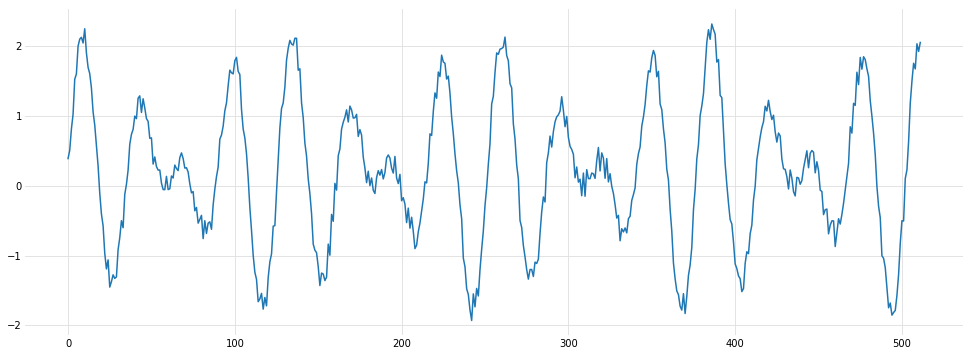

In [2]:
WAVEFORM_SELECT = 0 # select 0, 1 or 2

def create_time_series(datalen):
    # good waveforms
    frequences = [(0.2, 0.15), (0.35, 0.3), (0.6, 0.55)]
    freq1, freq2 = frequences[WAVEFORM_SELECT]
    noise = [np.random.random()*0.2 for i in range(datalen)]
    x1 = np.sin(np.arange(0,datalen) * freq1)  + noise
    x2 = np.sin(np.arange(0,datalen) * freq2)  + noise
    x = x1 + x2
    return x.astype(np.float32)

DATA_SEQ_LEN = 1024*128
data = create_time_series(DATA_SEQ_LEN)
plt.plot(data[:512])
plt.show()

## Hyperparameters

In [3]:
RNN_CELLSIZE = 64   # size of the RNN cells
NLAYERS = 2         # number of stacked RNN cells (needed for tensor shapes but code must be changed manually)
SEQLEN = 16          # unrolled sequence length
BATCHSIZE = 32      # mini-batch size
DROPOUT_PKEEP = 0.7 # probability of neurons not being dropped (should be between 0.5 and 1)

## Visualize training sequences
This is what the neural network will see during training.

Sample shape: (32, 16)
Label shape: (32, 16)
Excerpt from first batch:


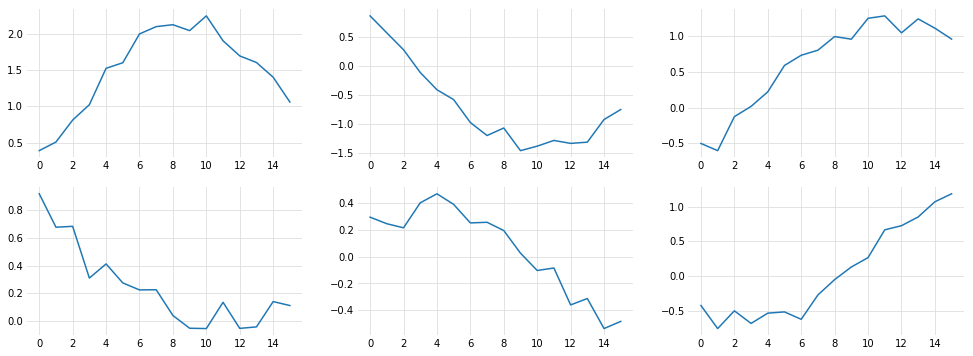

In [4]:
# The function dumb_minibatch_sequencer splits the data into batches of sequences sequentially.
for samples, labels, epoch in dumb_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=1):
    break
print("Sample shape: " + str(samples.shape))
print("Label shape: " + str(labels.shape))
print("Excerpt from first batch:")
subplot = 231
for i in range(6):
    plt.subplot(subplot)
    plt.plot(samples[i])
    subplot += 1
plt.show()

## The model definition
When executed, this function instantiates the Tensorflow graph for our model.

In [5]:
def model_rnn_fn(features, Hin, labels, dropout_pkeep):
    X = features
    batchsize = tf.shape(features)[0]
    seqlen = tf.shape(features)[1]
    
    #Here
    cells = [tf.nn.rnn_cell.GRUCell(RNN_CELLSIZE) for _ in range(NLAYERS)]
    # dropout needed between cell layers only: no output dropout on last cell
    dcells = [tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob = dropout_pkeep) for cell in cells[:-1]]
    dcells.append(cells[-1])
    cell = tf.nn.rnn_cell.MultiRNNCell(dcells, state_is_tuple=False)
    # X[BATCHSIZE, SEQLEN, 1], Hin[BATCHSIZE, CELLSIZE*NLAYERS]
    Yn, H = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32, initial_state=Hin)
    # Yn[BATCHSIZE, SEQLEN, RNN_CELLSIZE]
    Yn = tf.reshape(Yn, [batchsize*seqlen, RNN_CELLSIZE])
    Yr = tf.layers.dense(Yn, 1) # Yr [BATCHSIZE*SEQLEN, 1]
    Yr = tf.reshape(Yr, [batchsize, seqlen, 1]) # Yr [BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:] # Last output Yout [BATCHSIZE, 1]
    
    loss = tf.losses.mean_squared_error(Yr, labels) # labels[BATCHSIZE, SEQLEN, 1]
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    return Yout, H, loss, train_op

In [6]:
def model_identity_fn(features, Hin, labels, dropout_pkeep):
    # inputs shapes:
    # features [BATCHSIZE, SEQLEN, 1]
    # labels [BATCHSIZE, SEQLEN, 1]
    # Hin [BATCHSIZE, CELLSIZE*NLAYERS]
    
    # Goals:
    # Tranform input "features" into output "Yout"
    # Tranform input "Hin" into output "H" (these will be input and output states in an RNN)
    # Compute a loss between "Yout" and "labels" and minimize it
    
    # dummy model that does almost nothing (one trainable variable is needed)
    Yr = features * tf.Variable(tf.ones([]))
    H = Hin
    
    # Yr[BATCHSIZE, SEQLEN, 1]
    Yout = Yr[:,-1,:]
    # Last output in sequence Yout [BATCHSIZE, 1]
    
    # shapes:
    # Yr [BATCHSIZE, SEQLEN, 1]
    # labels[BATCHSIZE, SEQLEN, 1]
    loss = tf.losses.mean_squared_error(Yr, labels)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    train_op = optimizer.minimize(loss)
    
    # output shapes:
    # Yout [BATCHSIZE, 1]
    # H [BATCHSIZE, CELLSIZE*NLAYERS]
    return Yout, H, loss, train_op

## Instantiate the model

In [7]:
# placeholder for inputs
Hin = tf.placeholder(tf.float32, [None, RNN_CELLSIZE * NLAYERS])
samples = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
labels = tf.placeholder(tf.float32, [None, None, 1]) # [BATCHSIZE, SEQLEN, 1]
dropout_pkeep = tf.placeholder(tf.float32)

# instantiate the model
Yout, H, loss, train_op = model_rnn_fn(samples, Hin, labels, dropout_pkeep)

In [8]:
def prediction_run(prime_data, run_length):
    H_ = np.zeros([1, RNN_CELLSIZE * NLAYERS])
    Yout_ = np.zeros([1, 1])
    data_len = prime_data.shape[0]

    # prime the state from data
    if data_len > 0:
        Yin = np.array(prime_data)
        Yin = np.reshape(Yin, [1, data_len, 1]) # reshape as one sequence
        feed = {Hin: H_, samples: Yin, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
    
    # run prediction
    results = []
    for i in range(run_length):
        Yout_ = np.reshape(Yout_, [1, 1, 1]) # batch of a single sequence of a single vector with one element
        feed = {Hin: H_, samples: Yout_, dropout_pkeep: 1.0} # no dropout during inference
        Yout_, H_ = sess.run([Yout, H], feed_dict=feed)
        results.append(Yout_[0,0])
        
    return np.array(results), H_

In [9]:
def compute_RMSE(data):
    NUMRUNS=50
    PRIMELEN=256
    RUNLEN=64
    sum = 0
    datalen = data.shape[0]
    for i in range(NUMRUNS):
        offset = math.floor(np.random.random() * (datalen - PRIMELEN - RUNLEN))
        results, _ = prediction_run(data[offset:offset+PRIMELEN], RUNLEN)
        test_data = data[offset+PRIMELEN:offset+PRIMELEN+RUNLEN]
        sum += np.mean((results - test_data)**2)
    return math.sqrt(sum/NUMRUNS)

## Initialize Tensorflow session
This resets all neuron weights and biases to initial random values

In [10]:
# first input state
Hzero = np.zeros([BATCHSIZE, RNN_CELLSIZE * NLAYERS])
# variable initialization
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run([init])

[None]

## The training loop
Re-execute this cell to keep training

On waveform 1:
1. NB_EPOCHS=5, SEQLEN=8, no dropout, NLAYERS=1, BasicRNNCell, dumb_minibatch_sequencer, no state passing during training:<br>Not very good, some oscillation.
1. NB_EPOCHS=5, SEQLEN=16, no dropout, NLAYERS=1, BasicRNNCell, dumb_minibatch_sequencer, no state passing during training:<br>Not very good, some oscillation.
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, BasicRNNCell, dumb_minibatch_sequencer, no state passing during training:<br>Not very good, some oscillation.
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, dumb_minibatch_sequencer, no state passing during training:<br>Not very good, some oscillation. Bad track.
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, BasicRNNCell, dumb_minibatch_sequencer, YES: state passing during training:<br>Not very good, single frequency oscillation.
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, BasicRNNCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Not very good, single frequency oscillation.
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Very good!

On waveform 0:
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Not good!
1. NB_EPOCHS=10, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Quite good!
1. NB_EPOCHS=10, SEQLEN=32, dropout, NLAYERS=2, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Can still be broken! Running to 20 epochs kind of fixes it.

There does not seem to be a big difference between SEQLEN 16 and 32...

On waveform 2:
1. NB_EPOCHS=5, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Not so good!
1. NB_EPOCHS=10, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Quite good! But not always.
1. NB_EPOCHS=15, SEQLEN=32, no dropout, NLAYERS=1, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Very good!

The same with dumb_minibatch_sequence do not work.

1. NB_EPOCHS=10, SEQLEN=32, dropout=0.7, NLAYERS=2, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Very good! Always!
1. NB_EPOCHS=5, SEQLEN=32, dropout=0.7, NLAYERS=2, GRUCell, rnn_minibatch_sequencer, YES: state passing during training:<br>Quite good! Always! But 10 epochs is better.

In [16]:
NB_EPOCHS = 5

H_ = Hzero
losses = []
indices = []
# HERE
for i, (next_samples, next_labels, epoch) in enumerate(rnn_minibatch_sequencer(data, BATCHSIZE, SEQLEN, nb_epochs=NB_EPOCHS)):
    next_samples = np.expand_dims(next_samples, axis=2)
    next_labels = np.expand_dims(next_labels, axis=2)
    # HERE
    feed = {Hin: H_, samples: next_samples, labels: next_labels, dropout_pkeep: DROPOUT_PKEEP}
    Yout_, H_, loss_, train_op_ = sess.run([Yout, H, loss, train_op], feed_dict=feed)
    # print progress
    if i%100 == 0:
        print("epoch " + str(epoch) + ", batch " + str(i) + ", loss=" + str(np.mean(loss_)))
    if i%10 == 0:
        losses.append(np.mean(loss_))
        indices.append(i)
        
# final accuracy (RMSE = Root Mean Squared Error)
r = compute_RMSE(data)
print("final RMSE:" + str(r))

epoch 0, batch 0, loss=0.124382
epoch 0, batch 100, loss=0.0240332
epoch 0, batch 200, loss=0.0233415
epoch 1, batch 300, loss=0.020625
epoch 1, batch 400, loss=0.0200261
epoch 1, batch 500, loss=0.0231037
epoch 2, batch 600, loss=0.0199121
epoch 2, batch 700, loss=0.0284512
epoch 3, batch 800, loss=0.0190055
epoch 3, batch 900, loss=0.0198484
epoch 3, batch 1000, loss=0.0212695
epoch 4, batch 1100, loss=0.0212664
epoch 4, batch 1200, loss=0.0184451
final RMSE:0.24429569255992847


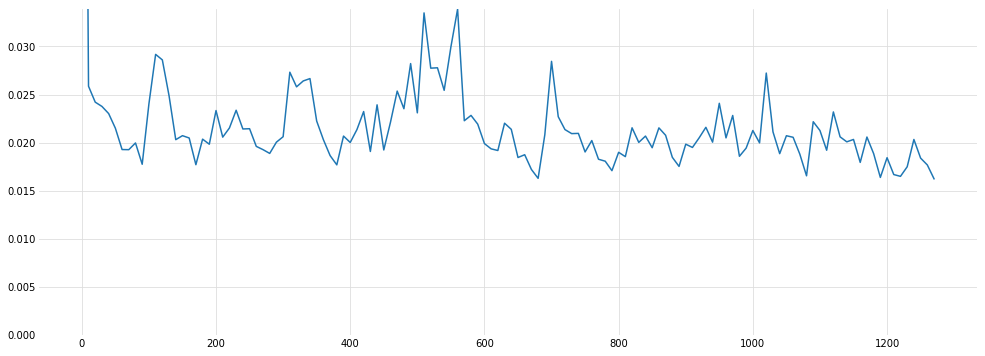

In [17]:
plt.ylim(ymax=np.amax(losses[1:])) # ignore first value for scaling
plt.plot(indices, losses)
plt.show()

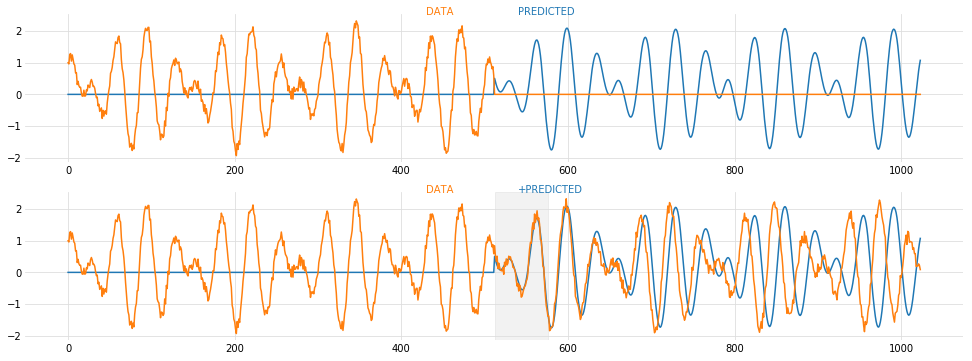

RMSE on 64 predictions (shaded area): 0.14870551658311307


In [18]:
PRIMELEN=512
RUNLEN=512
OFFSET=40

prime_data = data[OFFSET:OFFSET+PRIMELEN]

results, _ = prediction_run(prime_data, RUNLEN)

disp_data = data[OFFSET:OFFSET+PRIMELEN+RUNLEN]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.subplot(211)
plt.text(430,2.5,"DATA", color=colors[1])
plt.text(540,2.5,"PREDICTED", color=colors[0])
plt.plot(np.concatenate((np.zeros([PRIMELEN]), results)))
plt.plot(np.concatenate((prime_data, np.zeros([RUNLEN]))))
plt.subplot(212)
plt.text(430,2.5,"DATA", color=colors[1])
plt.text(540,2.5,"+PREDICTED", color=colors[0])
plt.plot(np.concatenate((np.zeros([PRIMELEN]), results)))
plt.plot(disp_data)
RMSELEN=64
plt.axvspan(PRIMELEN, PRIMELEN+RMSELEN, color='grey', alpha=0.1)
plt.show()

rmse = math.sqrt(np.mean((data[OFFSET+PRIMELEN:OFFSET+PRIMELEN+RMSELEN] - results[:RMSELEN])**2))
print("RMSE on {} predictions (shaded area): {}".format(RMSELEN, rmse))